In [6]:
import cv2 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import interpolate

In [7]:
#img1 = cv.imread('Hyun_Soo_template.jpg',0)
#img1_x=cv.drawKeypoints(img1,kp,img)
#cv.imwrite('sift_keypoints.jpg',img)
#plt.imshow(img1_x, cmap='gray', vmin=0, vmax=255)

In [8]:
#img2 = cv.imread('Hyun_Soo_target1.jpg',0)
#img2_x=cv.drawKeypoints(img2,kp,img)
#cv.imwrite('sift_keypoints.jpg',img)
#plt.imshow(img2_x, cmap='gray', vmin=0, vmax=255)

In [9]:
def visualize_find_match(img1, img2, x1, x2, img_h=500):
    assert x1.shape == x2.shape, 'x1 and x2 should have same shape!'
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    for i in range(x1.shape[0]):
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'b')
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'b.')
    plt.axis('off')
    plt.show()
    

In [10]:
def find_match(img1, img2):
    # To do
    sift1 = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift1.detectAndCompute(img1,None)

    sift2 = cv2.xfeatures2d.SIFT_create()
    kp2, des2 = sift2.detectAndCompute(img2,None)
    
    nbrs = NearestNeighbors(algorithm='auto').fit(des2)
    
    distances, indices =nbrs.kneighbors(des1,n_neighbors=2)
    
    x1 = np.empty((0,2))
    x2 = np.empty((0,2))
    
    for i in range(len(distances)):
        if (distances[i,0]/distances[i,1])<0.84:
            x1 = np.append(x1, kp1[i].pt)
            x2 = np.append(x2, kp2[indices[i,0]].pt)
    #print(good)
    #print(x2)
    x1 = x1.reshape(len(x1)//2,2)
    x2 = x2.reshape(len(x2)//2,2)
    #x1 = np.fliplr(x1)
    #x2 = np.fliplr(x2)
    
    return x1, x2


In [11]:
def align_image_using_feature(x1, x2, ransac_thr=0.2, ransac_iter=3000):
    # To do
    #ransac_thr = 0.01   
    #ransac_iter = 1
    x1 = np.fliplr(x1)
    x2 = np.fliplr(x2)

    m = len(x1)
    thresh = ransac_thr * np.sqrt(np.sum(      (np.max(x2,axis=0) - np.min(x1,axis=0))   **2   ))
     
    inlier_max = 0;
    
    for i in range(ransac_iter):      
        samples = np.random.choice(m, 3,replace=False)
        #samples = np.array([5,19,0])
    
        x1_draw = x1[samples, :]
        x2_draw = x2[samples, :]
        #print(x1_draw)
        #print(x2_draw)
        a = np.concatenate((x1_draw,np.array([[1],[1],[1]])),axis=1)
        
        b = x2_draw
        
        if np.linalg.matrix_rank(a)<len(a):
            continue
        X = np.linalg.inv(a)@b
        

        temp =np.array([[0,0,1]])
        
        Trans = np.concatenate((np.array(X.T),temp) , axis=0 )
         

    
        t1 = np.concatenate((x1,np.ones((m,1))) ,axis=1)
        transMat = t1 @ X
        
        #print(t1,X)

        error = transMat - x2
        
        table = np.array(np.linalg.norm( error,axis=1))
        
        #print(table) 
        
        inlier = len(np.where(table < thresh)[0])
        
        if (inlier > inlier_max):
            inlier_max = inlier
            A = Trans
        #print(thresh)
            
    return A

In [12]:
def warp_image(img, A, output_size):
    # To do
    im_warped = np.zeros(output_size)-1
    
    h,w = output_size
    
    for i in range(h):
        for j in range(w):
            x1 = np.array([[i], [j], [1]])  # coordinate in templete
            x2 = np.floor(A[:2, :] @ x1)# corresponding to coordinate in target
            
            if (x2[0] < img.shape[0] and  x2[1]<img.shape[1]):
                
                im_warped[i, j] = img[np.int(x2[0]), np.int(x2[1])] # obtain the graysacle in target
    
    #if len(np.where(im_warped<0))>0#####interpo
        #m,n = img.shape
        #mm = np.arange(m)
        #nn = np.arange(n)
        
        
    
    return im_warped

In [13]:
def get_differential_filter():
    # To do
    #filter_x = np.tile(np.array([1,0,-1]),(3,1))
    #filter_y = np.tile(np.vstack(np.array([1,0,-1])),3)
    #gaussian = np.array([[0,1,0],[1,2,1],[0,1,0]]) # Add the gaussian filter to mimic Park?
    
    #using self-defined solbelman filter instead.
    filter_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    filter_x = filter_y.T
    
    #print(filter_x)
    #print(filter_y)
    
    return filter_x, filter_y

In [14]:
def filter_image(im, filter):
    # To do
    # padding image in oder to let pic surrounded by zeros rim
    im_zero_pad = np.pad(im, ((1,1),(1,1)), 'constant')
    height,width = im.shape
    im_filtered = np.zeros(im.shape)
    
    for i in range(height):
        for j in range(width):
            cell = im_zero_pad[i:i+3,j:j+3]
            im_filtered[i,j] = np.sum(cell*filter)    # filtering each cell patch with selected kernel
    
    return im_filtered

In [15]:
def W_jacob(u,v):
    result =np.array([[u,v,1,0,0,0],[0,0,0,u,v,1]])
    return result
    

In [64]:
def align_image(template, target, A):
    # To do
    m,n = template.shape

    
    template = template/np.max(template)
    target = target/np.max(target)
    fu, fv = get_differential_filter()
    


    #W_jacob = @(u,v) [u,v,1,0,0,0;0,0,0,u,v,1]; # jacobian for dW(x,0)/dp

    dIdu = filter_image( template,fu );
    dIdv = filter_image( template,fv )

    H = np.zeros((6,6)) 

    # compute Hessian
    for uu in range(m):
        for vv in range(n):
            
            
            product = np.array([dIdu[uu,vv],dIdv[uu,vv]])@ W_jacob(uu,vv)

            H = H + np.multiply(np.vstack(product) , product);

    
    print(H)
    
    print(product)
    
    H_inv = np.linalg.pinv(H)
    W = A # W initialize
    
    
    print(H_inv)
    
    I_warped = warp_image(target, W, template.shape);
    
    epsilon = 0.008
    maxIter = 10
    iteration = 0
    
    err_list = [];
    erro_rate = 999;
    while(iteration < maxIter):
        
        I_warped = warp_image(target, W, template.shape)
        
        I_error = I_warped - template
        
        F = np.zeros(6)
        
        # compute Hessian
        for uu in range(m):
            for vv in range(n):
                
                product_1= np.array([dIdu[uu,vv],dIdv[uu,vv]])@ W_jacob(uu,vv)
                
                F = F +  product_1 * I_error[uu,vv]

        print(F)
        
        dp =np.array( H_inv @ F) 
        
        iteration = iteration + 1
        
        dW = np.array([[dp[0]+1, dp[1],dp[2]] , [dp[3], dp[4]+1, dp[5]], [ 0, 0, 1]])

        
        W = W @ np.linalg.pinv(dW);
        
        
        erro_rate = np.linalg.norm(I_error)/np.linalg.norm(I_warped)
        
        err_list.append(erro_rate)
        

        if(erro_rate < epsilon):
            print("Iteration stopped at error rate = %f "% erro_rate)
            break
   
    plt.plot(np.arange(len(err_list))+1,err_list , 'r-')
    
    A_align = W
    return A_align,err_list

In [65]:
def visualize_align_image(template, target, A, A_refined, errors=None):
    img_warped_init = warp_image(target, A, template.shape)
    img_warped_optim = warp_image(target, A_refined, template.shape)
    err_img_init = np.abs(img_warped_init - template)
    err_img_optim = np.abs(img_warped_optim - template)
    img_warped_init = np.uint8(img_warped_init)
    img_warped_optim = np.uint8(img_warped_optim)
    overlay_init = cv2.addWeighted(template, 0.5, img_warped_init, 0.5, 0)
    overlay_optim = cv2.addWeighted(template, 0.5, img_warped_optim, 0.5, 0)
    plt.subplot(241)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(242)
    plt.imshow(img_warped_init, cmap='gray')
    plt.title('Initial warp')
    plt.axis('off')
    plt.subplot(243)
    plt.imshow(overlay_init, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(244)
    plt.imshow(err_img_init, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.subplot(245)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(246)
    plt.imshow(img_warped_optim, cmap='gray')
    plt.title('Opt. warp')
    plt.axis('off')
    plt.subplot(247)
    plt.imshow(overlay_optim, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(248)
    plt.imshow(err_img_optim, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.show()

    if errors is not None:
        plt.plot(errors * 255)
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.show()

In [66]:
def track_multi_frames(template, img_list):
    # To do
    image_frame_num = len(img_list)
    
    template_updated = template  # initialize templete as given template
   
    A_list=[]
    A_align_list=[]
    template_list = []
    
    template_list.append(template_updated)
    for num in range(image_frame_num):
        print(num)
        
        input_frame = img_list[num] # set input i.e. target as image frame
        
        x1,x2 =  find_match(template_updated,input_frame)  # find match
        
        A = align_image_using_feature(x1, x2, 0.01, 3000)  # find A matrix
        
        A_aligned, err_list = align_image(template_updated, input_frame, A)  # optimize A matrix
        
        A_list.append(A)
        
        A_align_list.append(A_aligned) # store it for the frame
        
        template_updated =  warp_image(input_frame, A_aligned, template_updated.shape) # warp image as template for the next frame
        
        plt.imshow(template_updated, cmap='gray', vmin=0, vmax=255)
        
        template_updated =  np.array(template_updated, dtype='uint8')
        
        template_list.append(template_updated)
        
        #print(template_updated.shape)
        
        #print(np.min(template_updated ))
        
    return A_list,A_align_list, template_list


In [67]:
def visualize_track_multi_frames(template, img_list, A_list):
    bbox_list = []
    for A in A_list:
        boundary_t = np.hstack((np.array([[0, 0], [template.shape[0], 0], [template.shape[0], template.shape[1]],
                                        [0, template.shape[1]], [0, 0]]), np.ones((5, 1)))) @ A[:2, :].T
        
        bbox_list.append(np.fliplr(boundary_t))

    plt.subplot(221)
    plt.imshow(img_list[0], cmap='gray')
    print(bbox_list[0][:, 0],bbox_list[0][:, 1])
    plt.plot(bbox_list[0][:, 0], bbox_list[0][:, 1], 'r')
    plt.title('Frame 1')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(img_list[1], cmap='gray')
    plt.plot(bbox_list[1][:, 0], bbox_list[1][:, 1], 'r')
    plt.title('Frame 2')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(img_list[2], cmap='gray')
    plt.plot(bbox_list[2][:, 0], bbox_list[2][:, 1], 'r')
    plt.title('Frame 3')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(img_list[3], cmap='gray')
    plt.plot(bbox_list[3][:, 0], bbox_list[3][:, 1], 'r')
    plt.title('Frame 4')
    plt.axis('off')
    plt.show()

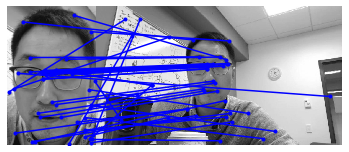

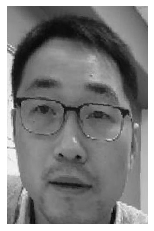

[[ 7.13719465e+08  2.87028002e+08  2.44944114e+06  2.70017677e+07
   2.21932315e+07  4.70097872e+04]
 [ 2.87028002e+08  2.88247869e+08  1.14353594e+06  2.21932315e+07
   5.77143701e+06  1.78400911e+04]
 [ 2.44944114e+06  1.14353594e+06  1.08064245e+04  4.70097872e+04
   1.78400911e+04 -8.40283737e+01]
 [ 2.70017677e+07  2.21932315e+07  4.70097872e+04  3.65363718e+08
   1.67900047e+08  1.18185856e+06]
 [ 2.21932315e+07  5.77143701e+06  1.78400911e+04  1.67900047e+08
   1.69516572e+08  8.52357745e+05]
 [ 4.70097872e+04  1.78400911e+04 -8.40283737e+01  1.18185856e+06
   8.52357745e+05  5.99770954e+03]]
[-435.08235294 -280.72941176   -0.96470588 -456.30588235 -294.42352941
   -1.01176471]
[[ 6.59396033e-09 -1.08075927e-09 -1.37707798e-06 -7.02937163e-11
  -1.19425487e-09  1.15810238e-07]
 [-1.08075927e-09  6.19982994e-09 -4.08584096e-07 -5.33263244e-10
   1.82683166e-10  6.34239435e-08]
 [-1.37707798e-06 -4.08584096e-07  4.47357204e-04  2.74197054e-08
   1.93504931e-07 -1.46265205e-05]
 [-

In [ ]:
if __name__ == '__main__':
    template = cv2.imread('./Hyun_Soo_template.jpg', 0)  # read as grey scale image
    target_list = []
    for i in range(4):
        target = cv2.imread('./Hyun_Soo_target{}.jpg'.format(i+1), 0)  # read as grey scale image
        target_list.append(target)

    x1, x2 = find_match(template, target_list[0])
    visualize_find_match(template, target_list[0],x1, x2)

    A = align_image_using_feature(x1, x2, ransac_thr=0.01, ransac_iter=3000)
    #print(A)
    img_warped = warp_image(target_list[0], A , template.shape)
    plt.imshow(img_warped, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    A_align,err_list = align_image(template, target_list[0], A)
    

    
    

In [ ]:
    visualize_align_image(template, target_list[0], A, A_align)
    
    A_list,A_align_list,t_list = track_multi_frames(template, target_list)
    visualize_track_multi_frames(template, target_list, A_list)
    visualize_track_multi_frames(template, target_list, A_align_list)
    

In [63]:
a = np.array([1,2,3])
np.multiply(np.vstack(a),a)

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])